In [3]:
import glob
import json
import os

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

import dask.dataframe as dd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

In [4]:
def load_data(path, size=2048):
    
    df_list = []
    glob_expression = f"{path}/*.csv"
    
    dtypes = {f'fps_{idx}':'bool' for idx in range(0, size)}
    dtypes['Score'] = 'float'
    
    for csv_filename in glob.glob(glob_expression):
        df_list.append(
            dd.read_csv(csv_filename, dtype=dtypes)
        )
        
    df = dd.concat(df_list).reset_index()

    return df.compute(scheduler="processes") #returns pandas dataframe!



def create_final_table_iterations(
    path_to_scores,
    path_to_iterations,
    path_to_result
):
    
    print(f'loading data from {path_to_scores}')
    raw_table = (
        load_data(path_to_scores)
        [['ZincID', 'Score']]
        .set_index('ZincID', drop=True)
    )

    
    d = {
        'iteration':[],
        'model':[],
        'type':[],
        'prediction_method':[],
        'tot_num_of_iterations':[],
        'add_to_train':[],
        'docked_size':[],
        'median_score':[],
        'percentage_of_hits':[],
        'added_molecules':[],
    }

    
    for pth, folders, files, in os.walk(path_to_iterations):
            for file in files:
                if (os.path.splitext(file)[-1] == '.json') and ('idx' not in os.path.split(file)[-1]):

                    model_name = file.split('_')[0].split('=')[1]
                    if (model_name.find('Classifier') == -1):
                        model_type = 'regressor'
                    else:
                        model_type = 'classifier'

                    prediction_method = file.split('_')[1].split('=')[1]
                    top_threshold = file.split('_')[3].split('=')[1]
                    add_to_train = file.split('_')[5]
                    iterations = int(file.split('_')[4].split('=')[1])
                    train = int(file.split('_')[2].split('=')[1])

                    with open(f'{pth}/{file}', 'r') as fle:

                        content = json.load(fle)

                        hits_num = 0

                        for idx in range(iterations + 1):

                            d['iteration'].append(idx)
                            hits_num += 100*len(set(content[f'iter_{idx}']) & set(content['buffer']))/len(content['buffer']) 
                            d['percentage_of_hits'].append(hits_num)
                            d['model'].append(model_name)
                            d['type'].append(model_type)
                            d['prediction_method'].append(prediction_method)
                            d['tot_num_of_iterations'].append(iterations)
                            d['add_to_train'].append(add_to_train)
                            d['docked_size'].append(train*(idx + 1))
                            d['median_score'].append(np.median(raw_table.loc[content[f'iter_{idx}']]))
                            d['added_molecules'].append(content[f'iter_{idx}'])
                            

    df = pd.DataFrame(d)
    df['percentage_of_docked'] = df['docked_size'] / 750_000
    df['hits_fraction'] = 0.01 * (1 - df['percentage_of_hits']/100) / (1 - df['percentage_of_docked'])
    print(f'writing to {path_to_result}/result_iterations_Morgan_size=2048_radius=2.csv')
    df.to_csv(
        f'{path_to_result}/result_iterations_Morgan_size=2048_radius=2.csv',
        
    )
    
    return df



def load_final_table_iterations(path):  
    
    df = pd.read_csv(f'{path}/result_iterations_Morgan_size=2048_radius=2.csv', index_col=0)  
    
    return df

In [5]:
common_path = '/storage/margaritakovaleva'
filename = 'Morgan_size=2048_radius=2'

df_4eiy = load_final_table_iterations(f'{common_path}/2022-07-22_tables/4eiy')
df_5zty = load_final_table_iterations(f'{common_path}/2022-07-22_tables/5zty')
df_AmpC = load_final_table_iterations(f'{common_path}/2021-06-15_big_datasets/AmpC_screen_table_1M')
df_D4 = load_final_table_iterations(f'{common_path}/2021-06-15_big_datasets/D4_screen_table_1M')

## Data for grid plot

In [6]:
def create_single_estimator(
    recall: float,
    full_size: int = 750_000,
    hits_frac: float = 0.01,
    num_iterations = 30,
):
    
    hits_size = full_size * hits_frac
    batch_size = 240_000 / num_iterations
    docked_size = np.arange(1, num_iterations + 2) * batch_size
    percentage_of_docked = docked_size / full_size
    
    found_hits = batch_size * hits_frac
    update_for_hits = [found_hits,]
    
    for idx in range(num_iterations):
        found_hits += recall * (hits_size - found_hits)
        update_for_hits.append(found_hits)
        
    update_for_hits = np.array(update_for_hits)
    percentage_of_hits = update_for_hits * 100 / hits_size
    
    estimator_df = pd.DataFrame({
        'percentage_of_docked': percentage_of_docked,
        'percentage_of_hits': percentage_of_hits,
        'model': 'Estimator',
        'tot_num_of_iterations': num_iterations
    })
    
    return estimator_df

def prepare_for_grid(df: pd.DataFrame):
    
    grid_columns = [
        'percentage_of_docked',
        'percentage_of_hits',
        'model',
        'tot_num_of_iterations'
    ]
    
    df_for_grid = df.query(
        '(add_to_train == "noadd") and '
        '(prediction_method == "LastModel")'
    )[grid_columns]
    
    
    
    return df_for_grid

In [7]:
##Информация из анализа single_model

recall_scores = {}
recall_scores[30] = (
    [0.1, 0.2 , 0.1 , 0.15],
    [0.05, 0.05, 0.1 , 0.1 ],
    [0.25, 0.35, 0.35, 0.25, 0.35],
    [0.1, 0.25, 0.05, 0.15789474, 0.15]
)
recall_scores[6] = (
    [0.08, 0.09, 0.11, 0.11],
    [0.08, 0.09, 0.11, 0.11],
    [0.37, 0.36, 0.35, 0.38, 0.32],
    [0.1, 0.1, 0.2, 0.17171717, 0.14]
)

recall_scores[12] = (
    [0.08, 0.04, 0.1, 0.06, 0.1],
    [0.08, 0.04, 0.1, 0.06, 0.1],
    [0.22, 0.36, 0.4,  0.34, 0.38],
    [0.12, 0.14, 0.12, 0.1,  0.16],
)

recall_scores[24] = (
    [0.16, 0.08, 0.12, 0.04],
    [0.16, 0.08, 0.12, 0.04],
    [0.52, 0.24, 0.32, 0.36, 0.28],
    [0.08, 0.08, 0.12, 0.24, 0.16],
)

In [8]:
dfs_for_grid = []
for num_iterations in [30, 24, 12, 6]:
    for df, model, recall_list in zip(
        (df_4eiy, df_5zty, df_AmpC, df_D4),
        ('AA2R', 'CB2', 'AmpC', 'D4'),
        recall_scores[num_iterations]
    ):

        estimators = [prepare_for_grid(df),]

        for recall in recall_list:
            estimators.append(create_single_estimator(recall, num_iterations=num_iterations))

        df_for_grid = pd.concat(estimators)
        df_for_grid['target'] = model
        dfs_for_grid.append(df_for_grid)

    df_for_grid = pd.concat(dfs_for_grid, ignore_index=True)

In [9]:
# import typing as tp

# def create_estimator(
#     df: pd.DataFrame,
#     recall: tp.Union[float, tp.List[float]] = 0.12,
#     full_size: int = 240_000,
#     hits_frac: float = 0.01,
#     tot_num_of_iterations_list: list = [6, 12, 24, 30]
# ):
#     hits_size = 750_000 * hits_frac
    
#     estimator_dfs = []
    
#     if isinstance(recall, float):
#         recall_list = [recall,] * len(tot_num_of_iterations_list)
#     else:
#         recall_list = recall

#     for tot_num_of_iterations, recall_score in zip(tot_num_of_iterations_list, recall_list):
        
#         batch_size: int = full_size // tot_num_of_iterations
#         docked_size = np.arange(tot_num_of_iterations + 1) * batch_size
        
#         found_hits = (
#             df.query("(model == 'RandomGaussianRegressor') and "
#                      "(percentage_of_docked == 0) and "
#                      f"(tot_num_of_iterations == '{tot_num_of_iterations}') and "
#                      "(add_to_train == 'noadd') and "
#                      "(prediction_method == 'LastModel')"
#                     )['percentage_of_hits'].mean() * hits_size / 100
#         )
        
#         update_for_hits = [found_hits,]
        
        
#         for idx in range(tot_num_of_iterations):
#             found_hits += recall_score * (hits_size - found_hits)
# #             update = recall * (hits_size - found_hits)
#             update_for_hits.append(found_hits)
# #             found_hits += update
#         update_for_hits = np.array(update_for_hits)
#         percentage_of_hits = update_for_hits * 100 / hits_size
        
#         estimator_df = pd.DataFrame({
#             'percentage_of_docked': docked_size,
#             'percentage_of_hits': percentage_of_hits,
#         })
#         estimator_df['model'] = 'Estimator'
#         estimator_df['tot_num_of_iterations'] = tot_num_of_iterations
        
#         estimator_dfs.append(estimator_df)
        
#     return pd.concat(estimator_dfs)
        
    

## Iterations plot 

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

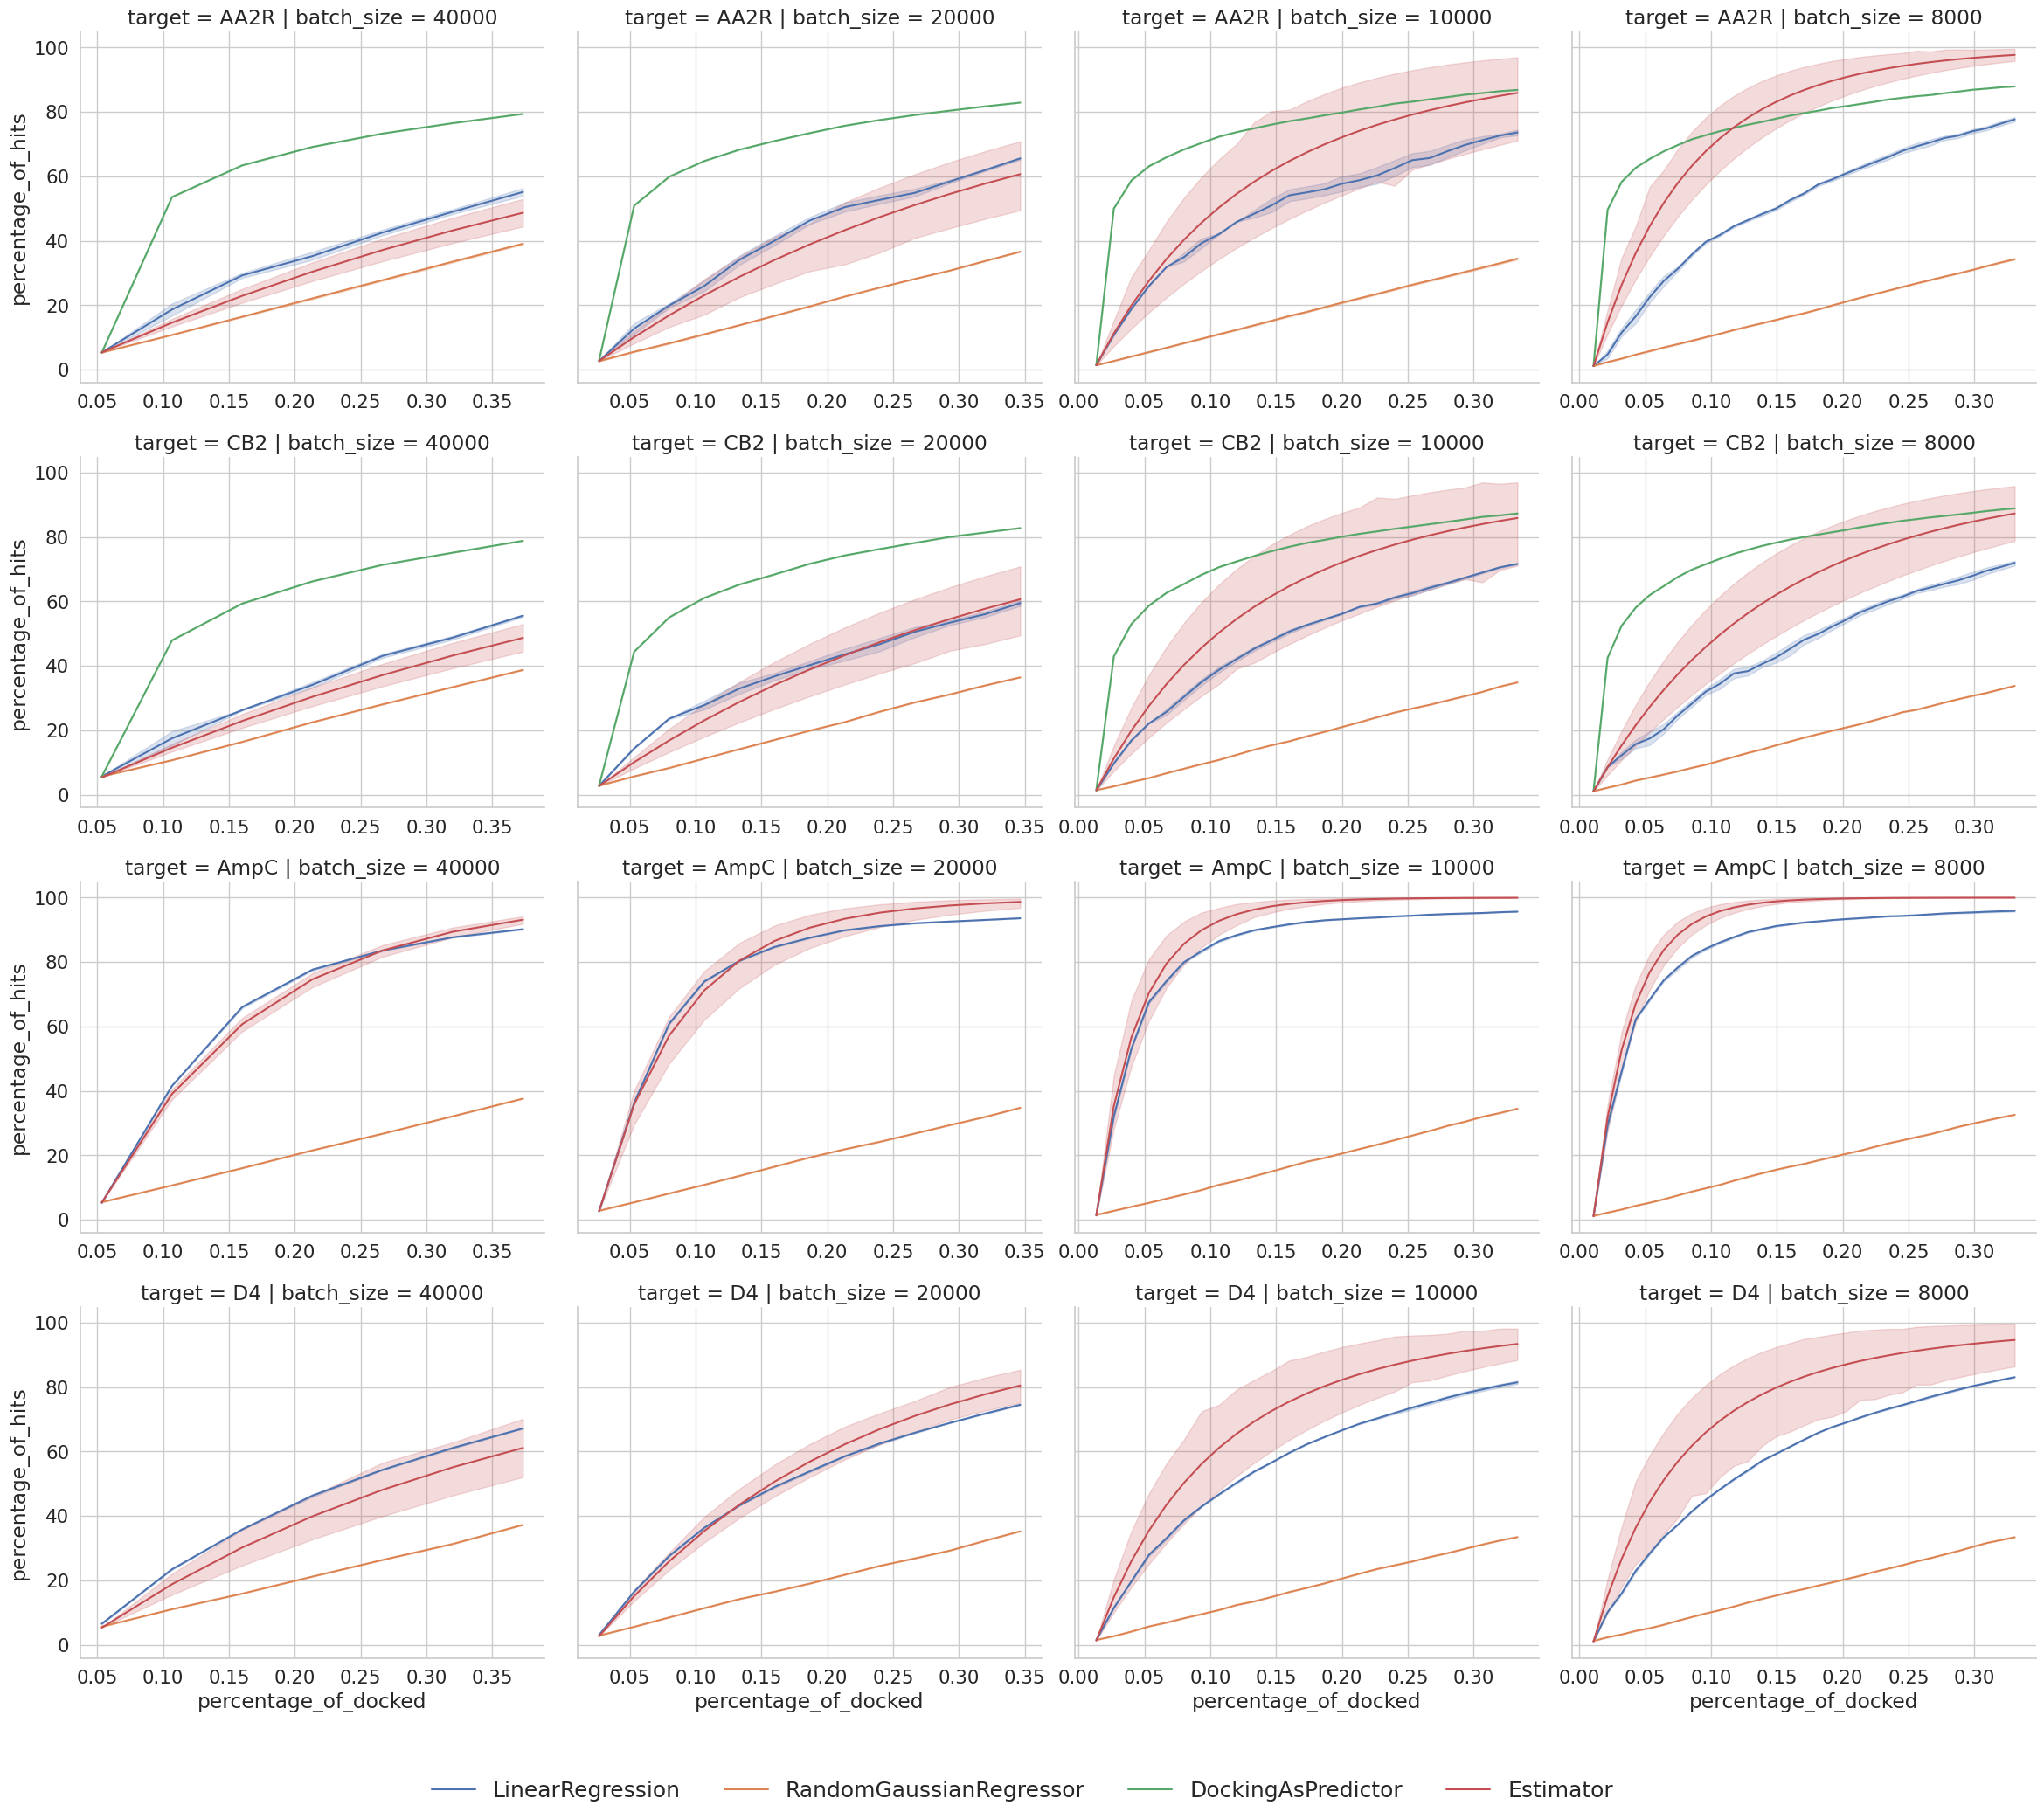

In [30]:
df_for_grid['hits_fraction'] = (
    (1 - df_for_grid['percentage_of_hits']/100) /
    (1 - df_for_grid['percentage_of_docked'])
).values

sns.set(font_scale=1.4, style="whitegrid")

df_for_grid['batch_size'] = 240_000 / df_for_grid.tot_num_of_iterations
plot = sns.relplot(
    data=df_for_grid,
    x="percentage_of_docked",
    y="percentage_of_hits",
    hue="model",
    hue_order=['LinearRegression', 'RandomGaussianRegressor',
               'DockingAsPredictor', 'Estimator'],
    col='batch_size',
    col_order=[40_000, 20_000, 10_000, 8_000],
    row='target',
    row_order=['AA2R', 'CB2', 'AmpC', 'D4'],
    markers=True,
    dashes=False,
    kind='line',
    #         legend = False,
    facet_kws={'sharey': True, 'sharex': False}
)

plot._legend.set_title('')
legend = sns.move_legend(plot, "lower center", ncol=4,
                         bbox_to_anchor=(0.5, -0.05), fontsize=18)
plt.box(on=True)
# sns.despine(plot)
# plt.subplots_adjust(right=0.88)

lg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

for ext in ('svg', 'png'):
    plt.savefig(f'../figures/figure_4_iterations.{ext}',
                bbox_extra_artists=(legend), bbox_inches='tight')


## Data for full table

In [20]:
from itertools import product

def create_table_middle(
    df: pd.DataFrame,
    target_name: str,
    model_list: list,
    tot_num_of_iterations_list: list = [6, 12, 24, 30]
):
    print(target_name)
    
    good_columns = [
        'model', 'tot_num_of_iterations',
        'prediction_method', 'add_to_train',
        'percentage_of_hits', 'percentage_of_docked'
    ]
    
    groupby_columns = [
        'model', 'tot_num_of_iterations',
        'prediction_method','add_to_train'
    ]
    
    prediction_method_list = ['LastModel', 'MeanRank', 'TopFromEveryModel']
    add_to_train_list = ['add', 'noadd']
    
    df_table = df.query("model in " + repr(model_list))[good_columns]
    
    df_table = df_table.loc[df_table.percentage_of_docked - 0.10666666666666667 < 0.0001]
    
    lines = []
    
    for model, tot_num_of_iterations, prediction_method, add_to_train in \
        product(model_list, tot_num_of_iterations_list, prediction_method_list, add_to_train_list):
        
        current_df = df_table.query(f"(model == {repr(model)}) and "
                              f"(tot_num_of_iterations == {repr(tot_num_of_iterations)}) and "
                              f"(prediction_method == {repr(prediction_method)}) and "
                              f"(add_to_train == {repr(add_to_train)})"
                              )
    
        if current_df.empty:
            print(model, tot_num_of_iterations, prediction_method, add_to_train)
            
        else:
            lines.append(
                current_df
                .groupby(groupby_columns)
                .agg(['mean', 'std', 'count'])
            )
            
    df_final = pd.concat(lines)
    
    mean_str = []
    for _, row in df_final.iterrows():
        mean_str.append("{mean:.3f} ± {std:.3f}".format(
            mean=row[('percentage_of_hits',  'mean')],
            std=row[('percentage_of_hits',   'std')]
        ))
    df_final['metrics'] = mean_str

    return df_final

In [24]:
from itertools import product

def create_full_table_docking(
    df: pd.DataFrame,
    target_name: str,
    model_list: list,
    tot_num_of_iterations_list: list = [6, 12, 24, 30]
):
    print(target_name)
    
    good_columns = [
        'model', 'tot_num_of_iterations', 'iteration',
        'prediction_method', 'add_to_train', 'percentage_of_hits'
    ]
    
    groupby_columns = [
        'model', 'tot_num_of_iterations','add_to_train'
    ]
    
    add_to_train_list = ['add', 'noadd']
    
    df_table = df.query("model in " + repr(model_list))[good_columns]
    
    df_table = df_table.loc[df_table.iteration == df_table.tot_num_of_iterations]
    df_table = df_table.drop('iteration', axis=1)
    
    lines = []
    
    for model, tot_num_of_iterations, add_to_train in \
        product(model_list, tot_num_of_iterations_list, add_to_train_list):
        
#         try:
#             percentage_of_hits = \
#                 df_table[f'{model} {tot_num_of_iterations} {prediction_method} {add_to_train}']
#         except KeyError:
#             percentage_of_hits = None

        current_df = df_table.query(f"(model == {repr(model)}) and "
                              f"(tot_num_of_iterations == {repr(tot_num_of_iterations)}) and "
                              f"(add_to_train == {repr(add_to_train)})"
                              )
    
        if current_df.empty:
            print(model, tot_num_of_iterations, add_to_train)
            
        else:
            lines.append(
                current_df
                .groupby(groupby_columns)
                .agg(['mean', 'std', 'count'])
            )
            
    df_final = pd.concat(lines)
    
    mean_str = []
    for _, row in df_final.iterrows():
        mean_str.append("{mean:.2f} ± {std:.2f}".format(
            mean=row[('percentage_of_hits',  'mean')],
            std=row[('percentage_of_hits',   'std')]
        ))
    df_final['metrics'] = mean_str

    return df_final

In [25]:
def table_10(df):
    df_10 = df.query(
        '(model == "LinearRegression") and '
        '(percentage_of_docked == 0.10666666666666667)'
    ).groupby(
        ['tot_num_of_iterations', 'prediction_method', 'add_to_train']
    )['percentage_of_hits'].agg(['mean', 'std', 'count'])

    mean_str = []
    for _, row in df_10.iterrows():
        mean_str.append("{mean:.2f} ± {std:.2f}".format(
            mean=row['mean'],
            std=row['std']
        ))
    df_10['metrics'] = mean_str
    
    return df_10

In [26]:
def table_10_docking(df):
    
    df_10 = df.query(
        '(model == "DockingAsPredictor") and '
        '(percentage_of_docked == 0.10666666666666667)'
    ).groupby(
        ['tot_num_of_iterations', 'add_to_train']
    )['percentage_of_hits'].agg(['mean', 'std', 'count'])

    mean_str = []
    for _, row in df_10.iterrows():
        mean_str.append("{mean:.2f} ± {std:.2f}".format(
            mean=row['mean'],
            std=row['std']
        ))
    df_10['metrics'] = mean_str
    
    return df_10

In [29]:
# final_4eiy = create_full_table(df_4eiy, '4eiy', ['LinearRegression'])
# final_5zty = create_full_table(df_5zty, '5zty', ['LinearRegression'])
# final_AmpC = create_full_table(df_AmpC, 'AmpC', ['LinearRegression'])
# final_D4 = create_full_table(df_D4, 'D4', ['LinearRegression'])

final_4eiy_d = create_full_table_docking(df_4eiy, '4eiy', ['DockingAsPredictor'])
final_5zty_d = create_full_table_docking(df_5zty, '5zty', ['DockingAsPredictor'])

4eiy
5zty


### LinearSVR

In [55]:
df_linear_svr = df_4eiy.query('prediction_method == "LastModel"')

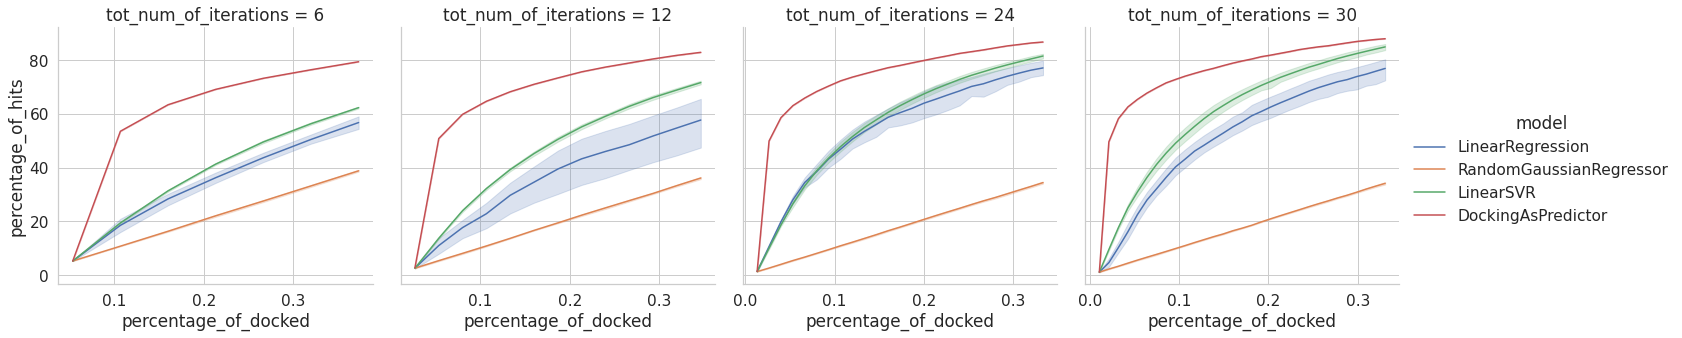

In [56]:
plot = sns.relplot(
    data=df_linear_svr,
    x="percentage_of_docked",
    y="percentage_of_hits",
    hue="model",
#     hue_order = ['LinearRegression', 'RandomGaussianRegressor', 'DockingAsPredictor', 'Estimator'],
    col = 'tot_num_of_iterations',
    col_order = [6, 12, 24, 30],
#     row = 'target',
#     row_order = ['AA2R', 'CB2', 'AmpC', 'D4'],
    markers=True,
    dashes=False,
    kind='line',
#         legend = False,
    facet_kws={'sharey': True, 'sharex': False}
)